# Imports

### First Install OpenCV

In [17]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [18]:
import torch
import cv2
import json #for label processing
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torchvision import models as models
from torchvision import models as vision_models
import warnings

In [19]:
warnings.filterwarnings('ignore')

In [20]:
# learning parameters
lr = 0.00001
epochs = 75
batch_size = 32

In [21]:
normalize = transforms.Normalize(mean=[0.3605, 0.3185, 0.2916],
                                 std=[0.3822, 0.3564, 0.3438])

# Prepare Dataset

In [22]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['Id']
        labels = self.csv['labels']
        
        self.all_labels = np.array(([json.loads(y) for y in labels]))
        #let train be 0.85 total. then choose .75 of it as train and .25 validation
        self.train_ratio = int(0.80 * 0.85 * len(self.csv))
        self.valid_ratio = int(0.20 * 0.85 * len(self.csv))
        self.test_ratio = int(0.15 * len(self.csv))
        
        self.text = self.csv[:]['Text']
        
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[self.train_ratio:-self.test_ratio])
            self.labels = list(self.all_labels[self.train_ratio:-self.test_ratio])
            
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                normalize
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            print(f"Number of testing images: {self.test_ratio}")
            self.image_names = list(self.all_image_names[-self.test_ratio:])
            self.labels = list(self.all_labels[-self.test_ratio:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                normalize
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"/scratch/vk2161/CV/orig_dataset/400posters/{self.image_names[index]}")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]

        #Tesseract was not able to parse some of the poster so handle null cases
        des = "" if self.text[index] != self.text[index] else self.text[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            'text' : des
        }

# Resnet 50

In [23]:
from torchvision import models as models
import torch.nn as nn

def resnetmodel(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 19 classes in total
    model.fc = nn.Linear(2048, 19)
    return model

# Train

In [24]:
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('***** Training *****')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

# Validation

In [25]:
def validate(model, dataloader, criterion, val_data, device):
    print('***** Validating *****')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

### Init Device

In [26]:
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device =", device)

Using device = cuda


### Init train/test/validation data

In [41]:
# read the training csv file
train_csv = pd.read_csv('/scratch/vk2161/CV/orig_dataset/modified_ocr.csv')

# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 28212
Number of validation images: 7053


# Model Init and optimizer

In [28]:
#intialize the model
model = resnetmodel(pretrained=True, requires_grad=True).to(device)

# optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()

# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-6, nesterov=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size_up=1000)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=20)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7,12,15], gamma=0.1)

### Train the model

In [ ]:
# start the training and validation
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"\n\nEpoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    #adaptive learning rate
    scheduler.step()
    valid_epoch_loss = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"  Train Loss: {train_epoch_loss:.4f}")
    print(f'  Val Loss: {valid_epoch_loss:.4f}')
    
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
        }, '/scratch/srs9969/output/mode1_16Dec_8515_930am_'+ str(epoch) +'.pth')

### Save the model

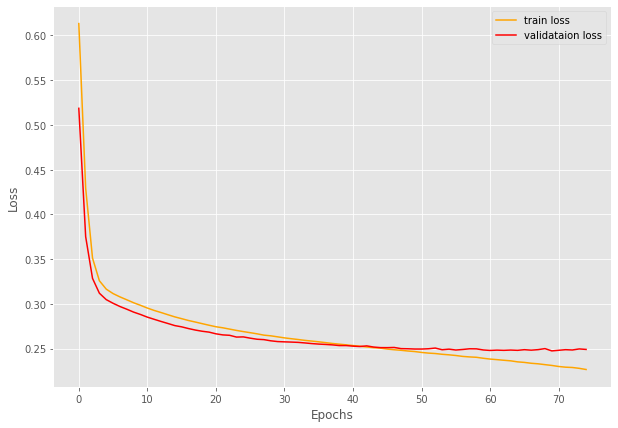

In [44]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# initialize the computation device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#intialize the model
# model = models.model(pretrained=False, requires_grad=False).to(device)
# load the model checkpoint
checkpoint = torch.load('/scratch/srs9969/output/mode1_15Dec_8515_720pm_74.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
device = torch.device('cpu')

In [49]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Load the Spacy Model

In [42]:
import spacy
spacy.load('en')
nlp = spacy.load('en_pytt_bertbaseuncased_lg')

# Ensemble

In [50]:
class EnsembleResnet(nn.Module):
    def __init__(self, resnet, spacy, nb_classes=10):
        super(EnsembleResnet, self).__init__()
        self.resnet = resnet
        self.spacy = spacy
        # Remove last linear layer
        self.resnet.fc = nn.Identity()
        
        # Create new classifier
        # The reason for adding 2048 + 768 is spacy
        self.classifier = nn.Linear(2048+768, 19)
        
    def forward(self, img, txt):
        
        r = self.resnet(img)
        r = r.view(r.size(0), -1)
        
        s = None
        
        if len(txt) == 0:
            s = np.zeros(768, dtype=float)
            s = torch.tensor(s, dtype=torch.float32)            
        else:
            s = self.spacy(txt).vector
            s = torch.tensor(s)
            s = s.view(s.size(0), -1)
        
        s = s.reshape((1,768))
        s = s.to(device)
        
        res = torch.cat((r, s), dim=1)
        res = self.classifier(F.relu(res))
        return res

In [51]:
ensemble_model = EnsembleResnet(model, nlp)

In [52]:
# train_csv = pd.read_csv('../input/movie-classifier/Multi_Label_dataset/train.csv')
# genres = train_csv.columns.values[1]
labels = train_csv['labels']
genres = np.array(([json.loads(y) for y in labels]))

# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv, train=False, test=True
)
test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=True
)

Number of testing images: 6223


## Ensemble Prediction

In [53]:
import torch.nn.functional as F

In [54]:
from sklearn.metrics import hamming_loss
h_loss = 0
test_size = 0

input_matrix = None
output_matrix = None

for counter, data in enumerate(test_loader):
    image, target, text = data['image'].to(device), data['label'], data['text']
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    # get the predictions by passing the image through the model
    
    txt = ""
    
    if len(text) != 0:
        #print("Text here", text)
        txt = ''.join(text)
    
    #print(text)
    
    input_x = (image, txt)
    outputs = ensemble_model(image, txt)
    outputs = torch.sigmoid(outputs)
   
    #outputs = outputs.detach().cpu()
    
    #we need to get top k result depending on the no of labels our dataset has
    target_labels = data['label']
    top_k = torch.count_nonzero(target_labels)
    
    # get the top_k result
    result, indices = torch.topk(outputs, k=top_k ,largest=True)
    
    #flatten the indices
    indices = indices.flatten()
    #unsqueeze the indices
    indices = indices.unsqueeze(0)
    
    #We have the indices now, now lets create a one-hot encoding tensor
    predicted_labels = torch.zeros(indices.size(0), 19).scatter_(1, indices, 1)
    
    #Calculate the hamming loss
    h_loss += hamming_loss(target_labels, predicted_labels)
    test_size = test_size + 1 
    
    input_matrix = target_labels if input_matrix is None else torch.vstack((input_matrix, target_labels))
    output_matrix = predicted_labels if output_matrix is None else torch.vstack((output_matrix, predicted_labels))    
    
print(h_loss/test_size)

0.18405406091154564


## Inference/Evaluation

In [63]:
genresList = pd.read_csv('/scratch/srs9969/genre_List.csv')['Genres']

In [65]:
genresList

0           Animation
1           Adventure
2              Family
3              Comedy
4             Fantasy
5             Romance
6               Drama
7              Action
8               Crime
9            Thriller
10             Horror
11            History
12    Science Fiction
13            Mystery
14                War
15              Music
16        Documentary
17            Western
18           TV Movie
Name: Genres, dtype: object

In [ ]:
input_matrix = input_matrix.detach().cpu().numpy()
output_matrix = output_matrix.detach().cpu().numpy()

In [66]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# For each class
precision = precision_score(input_matrix, output_matrix, average=None)
recall = recall_score(input_matrix, output_matrix, average=None)
f1_score = f1_score(input_matrix, output_matrix, average=None)
h_loss = hamming_loss(input_matrix, output_matrix)

#Send this to a Map 
precision_map = dict()
for p, g in zip (precision, genresList):
    precision_map[g] = p

recall_map = dict()
for r, g in zip (recall, genresList):
    recall_map[g] = r

f1_score_map = dict()
for f1, g in zip (f1_score, genresList):
    f1_score_map[g] = f1
    



In [67]:
print(precision)
print(recall)
print(f1_score)

[1.         0.17103236 0.04166667 0.5        0.1257485  0.21333333
 0.52422145 0.19696084 0.17647059 0.21730068 0.25477707 0.06802721
 0.23125    0.07488987 0.04044877 0.02409639 0.028      0.01262626
 0.05809524]
[8.33333333e-03 2.50000000e-01 6.62251656e-03 5.86854460e-04
 6.58307210e-02 2.31368187e-01 1.00564222e-01 3.76957494e-01
 3.50584307e-02 3.88630009e-01 5.73888092e-02 8.96860987e-02
 2.43956044e-01 1.08280255e-01 7.17277487e-01 7.78210117e-03
 8.98587933e-03 3.81679389e-02 3.26203209e-01]
[0.01652893 0.2031107  0.01142857 0.00117233 0.08641975 0.22198506
 0.16875522 0.25873321 0.05849582 0.27874332 0.09367681 0.07736944
 0.23743316 0.08854167 0.07657909 0.01176471 0.01360544 0.01897533
 0.09862571]


In [68]:
from collections import Counter

p = dict(Counter(precision_map).most_common(5))
print(p)

r = dict(Counter(recall_map).most_common(5))
print(r)

f1 = dict(Counter(f1_score_map).most_common(5))
print(f1)

{'Animation': 1.0, 'Drama': 0.5242214532871973, 'Comedy': 0.5, 'Horror': 0.25477707006369427, 'Science Fiction': 0.23125}
{'War': 0.7172774869109948, 'Thriller': 0.3886300093196645, 'Action': 0.3769574944071588, 'TV Movie': 0.32620320855614976, 'Adventure': 0.25}
{'Thriller': 0.2787433155080214, 'Action': 0.25873320537428024, 'Science Fiction': 0.2374331550802139, 'Romance': 0.22198505869797228, 'Adventure': 0.20311070448307408}


In [51]:
def testData(model, dataloader, criterion, test_data, device):
    print('Testing')
    counter = 0
    test_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(test_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            test_running_loss += loss.item()
        
        test_loss = test_running_loss / counter
        return test_loss

In [52]:
test_loss = testData(model, test_loader, criterion, test_data, device)
print(test_loss)

Testing


100%|██████████| 6417/6417 [01:08<00:00, 93.26it/s]

0.7125740955788825
